# **Campus Management**
#### **Group Members:** : *Devanshi, Aneesh, Kosi*
---

In [39]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from tabulate import tabulate

import warnings
warnings.filterwarnings('ignore')


### Importing the dataset

In [40]:
train_data = pd.read_csv('../2/Train_Data.csv')

In [41]:
train_data.head(10)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,etest_p,mba_p,specialisation,workex,status
0,M,73.976975,Central,77.392691,Others,Science,73.623151,Sci&Tech,84.498310,67.207006,Mkt&HR,Yes,Placed
1,M,62.000000,Others,62.000000,Others,Commerce,60.000000,Comm&Mgmt,63.000000,52.380000,Mkt&HR,Yes,Placed
2,M,80.965242,Others,67.104275,Others,Science,72.482621,Sci&Tech,91.343588,71.392313,Mkt&Fin,No,Placed
3,M,52.000000,Others,65.000000,Others,Arts,57.000000,Others,75.000000,59.810000,Mkt&Fin,Yes,Not Placed
4,F,69.000000,Central,62.000000,Central,Science,66.000000,Sci&Tech,75.000000,67.990000,Mkt&HR,No,Not Placed
5,M,78.762370,Others,78.663054,Others,Commerce,70.281069,Comm&Mgmt,67.441772,65.318049,Mkt&Fin,Yes,Placed
6,M,51.794497,Others,40.985605,Others,Science,62.126648,Others,65.862469,52.249751,Mkt&HR,No,Not Placed
7,M,59.805924,Central,61.451481,Others,Commerce,60.000000,Comm&Mgmt,62.451481,57.025957,Mkt&HR,Yes,Placed
8,M,77.351318,Central,74.834674,Others,Science,73.487712,Sci&Tech,80.123994,68.001657,Mkt&HR,Yes,Placed
9,M,76.500000,Others,97.700000,Others,Science,78.860000,Sci&Tech,97.400000,74.010000,Mkt&Fin,No,Placed


### Visualizations

Looking into class imbalance:

In [42]:
print(pd.value_counts(train_data['status']))

status
Placed        439
Not Placed    231
Name: count, dtype: int64


Text(0, 0.5, 'Count')

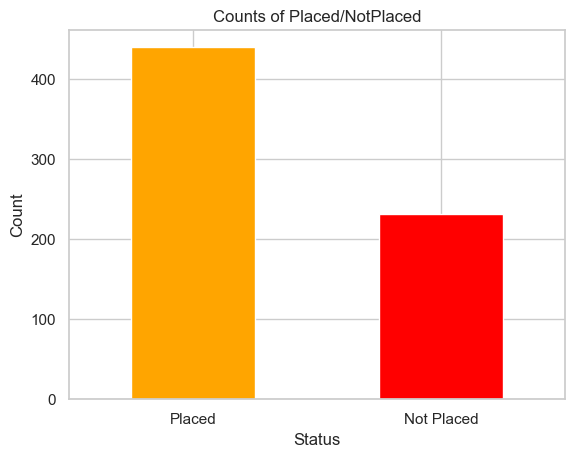

In [43]:
LABELS = ["Placed", "Not Placed"]
class_counts = pd.value_counts(train_data['status'], sort = True)
class_counts.plot(kind = 'bar', rot=0, color=['orange','red']) 
plt.title('Counts of Placed/NotPlaced')
plt.xticks(range(2), LABELS)
plt.xlabel("Status")
plt.ylabel("Count")

There are 439 instances of "Placed" and 231 instances of "Not Placed," according to the status variable's distribution. This suggests that the number of "Placed" instances is nearly twice that of "Not Placed" cases. Although there is an imbalance here, it is not a severe one. Because of its moderate degree of imbalance, extensive resampling approaches might not be necessary.

### Distribution of categories based on the target variable

In [44]:
degree_t_counts = train_data['degree_t'].value_counts()
degree_t_counts

degree_t
Sci&Tech     257
Comm&Mgmt    209
Others       204
Name: count, dtype: int64

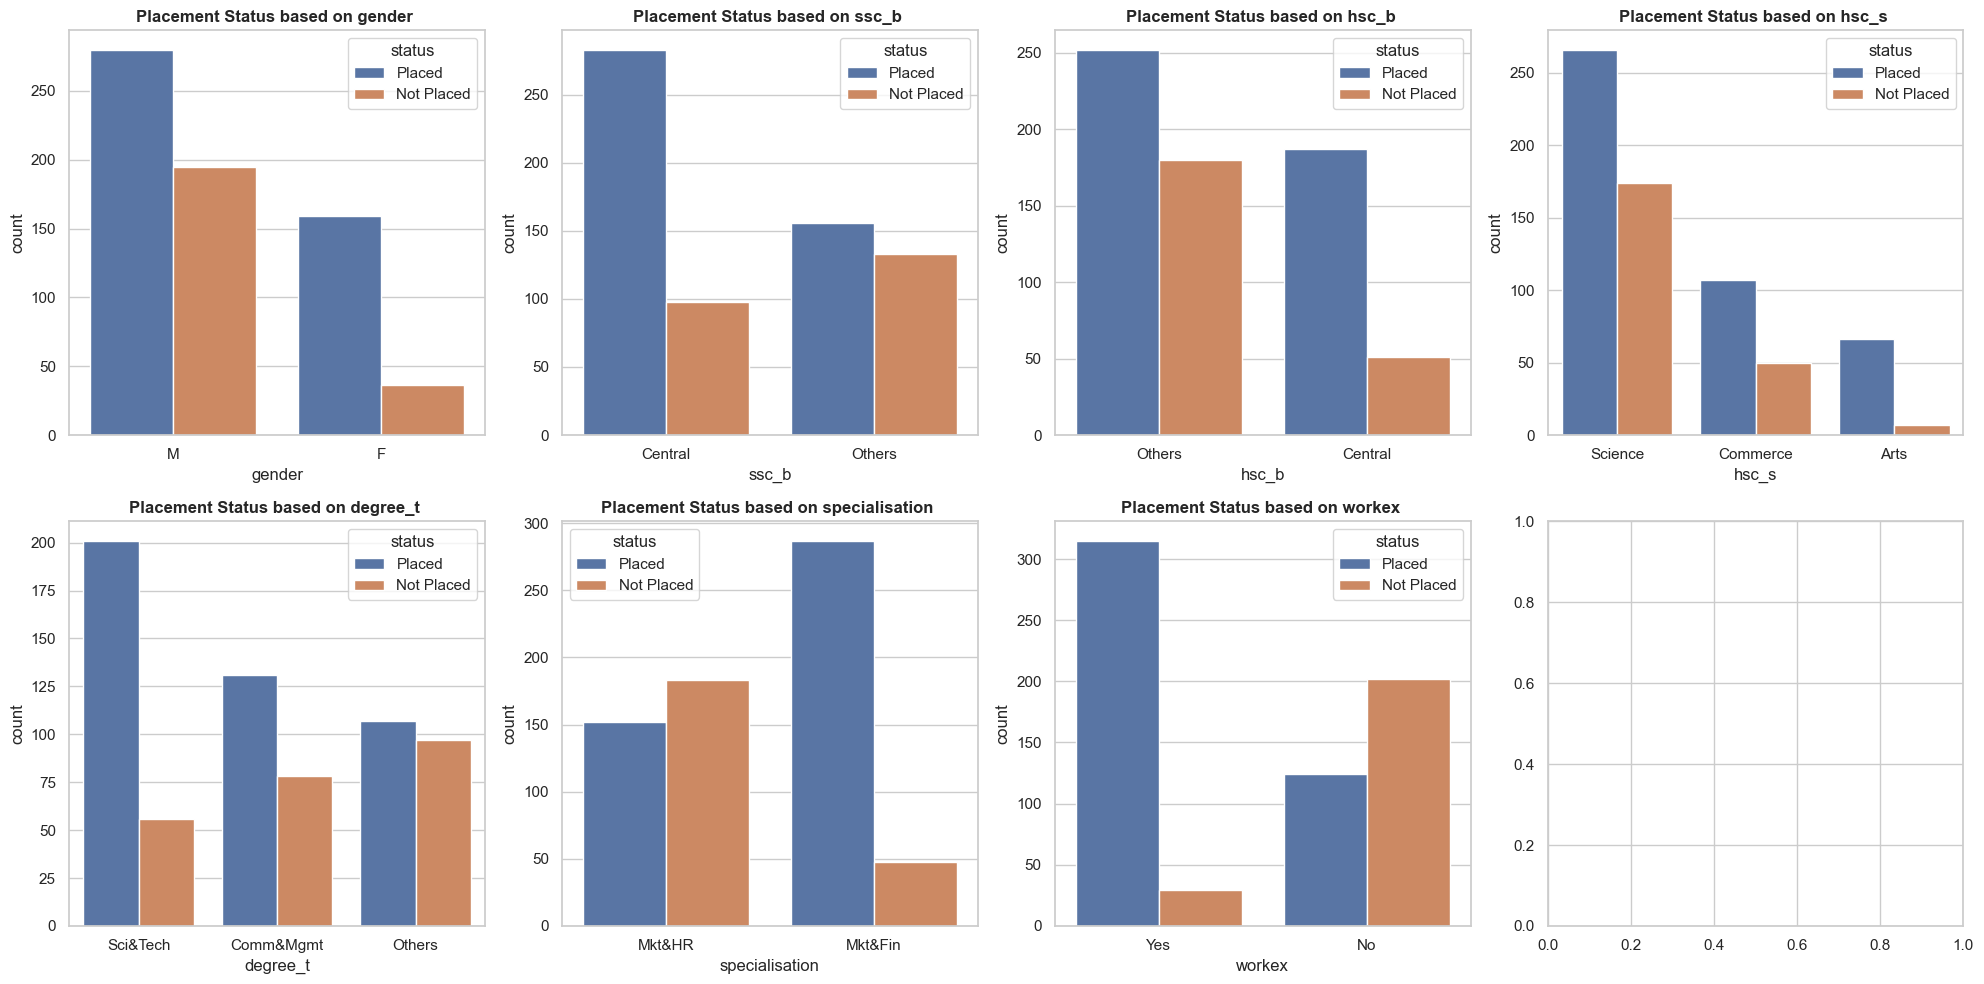

In [45]:
categorical_features = ['gender', 'ssc_b', 'hsc_b', 'hsc_s', 'degree_t', 'specialisation', 'workex']


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    sb.countplot(x=feature, hue='status', data=train_data,  ax=axes[i])
    # sb.lineplot(x=train_data.index, y=feature, data=train_data, ax=axes[i])
    axes[i].set_title(f'Placement Status based on {feature} ',fontweight='bold')

plt.tight_layout()
plt.show()

Based on the bar plots:
- According to **SSC Board placement status (ssc_b)**, Central Board students appear to be placed more frequently than "Others" category students.
- According to **HSC Board placement(hsc_b)**, Central board students are placed at a higher rate than "Others," much like SSC Board students are.
- The Science **stream** has the greatest placement rate, followed by the Commerce stream, while the Arts stream has the lowest.
- **Degree Type (degree_t)** Placement Status: Students in the Science & Tech field are best placed, followed by those in the Communication & Management field, while "Others" have the lowest placements.
- Placement Status according to **Specialisation**: Students with a concentration in Mkt&Fin, appear to be placed more frequently than those with a concentration in Mkt&HR.
- **Work Experience**-Based Placement Status (workex): Students who report having work experience (Yes) are placed more frequently than those who report having none (No).

### **Preprocessing**

#### Missing Values

In [46]:
train_data.isnull().sum()

gender            0
ssc_p             0
ssc_b             0
hsc_p             0
hsc_b             0
hsc_s             0
degree_p          0
degree_t          0
etest_p           0
mba_p             0
specialisation    0
workex            0
status            0
dtype: int64

> ### *No Null values, so no need to process this data*

#### Outlier Detection

In [47]:
train_data.describe()

,ssc_p,hsc_p,degree_p,etest_p,mba_p
count,670.000000,670.000000,670.000000,670.000000,670.000000
mean,68.960017,65.203006,65.229034,73.740025,62.993108
std,10.182563,11.222577,7.157608,12.101840,5.126855
min,42.864579,37.106246,50.000000,50.000000,51.290000
25%,61.619318,60.431420,60.000000,64.199327,59.431996
50%,68.332563,64.753270,64.906329,72.677821,62.481656
75%,77.130019,71.390402,70.271632,83.955186,66.864202
max,89.400000,97.700000,91.000000,97.938047,77.890000


The maximum value of the all the features seems to be in a reasonable range. 

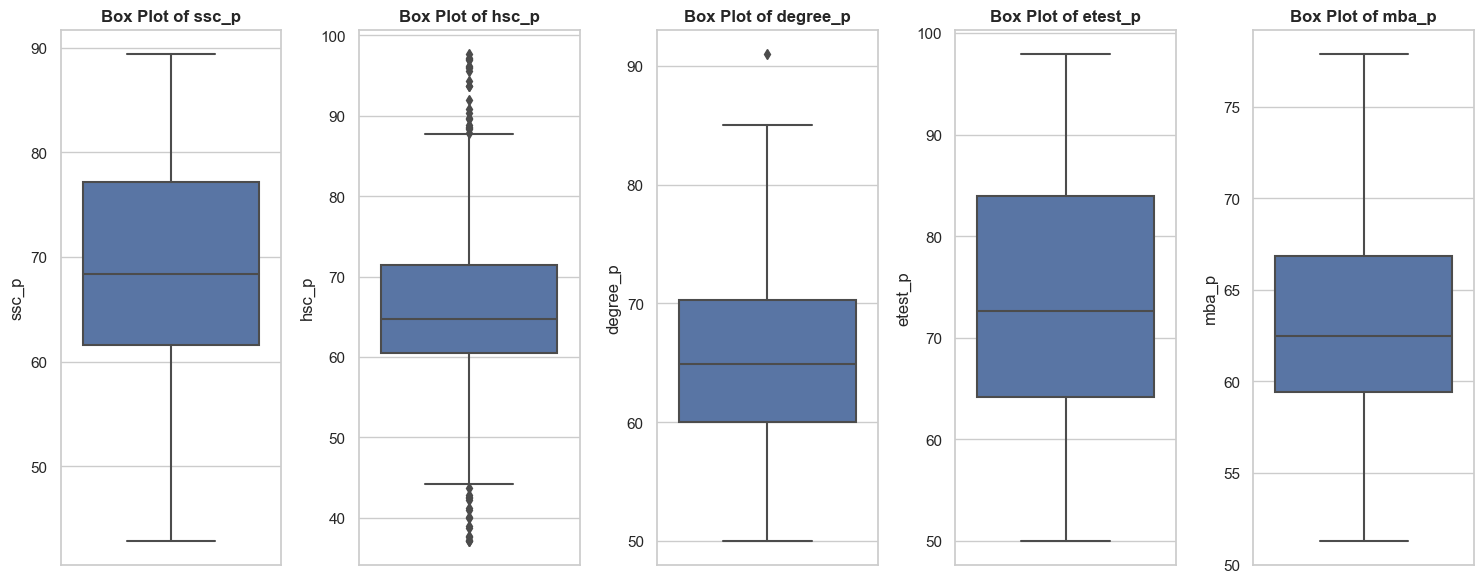

In [48]:
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

num_cols = 5
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols
num_rows = 1 
plt.figure(figsize=(15, num_rows * 6))
sb.set(style="whitegrid") 

for i, column in enumerate(numerical_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sb.boxplot(y=train_data[column])
    plt.title(f'Box Plot of {column}',fontweight='bold')

plt.tight_layout()
plt.show()

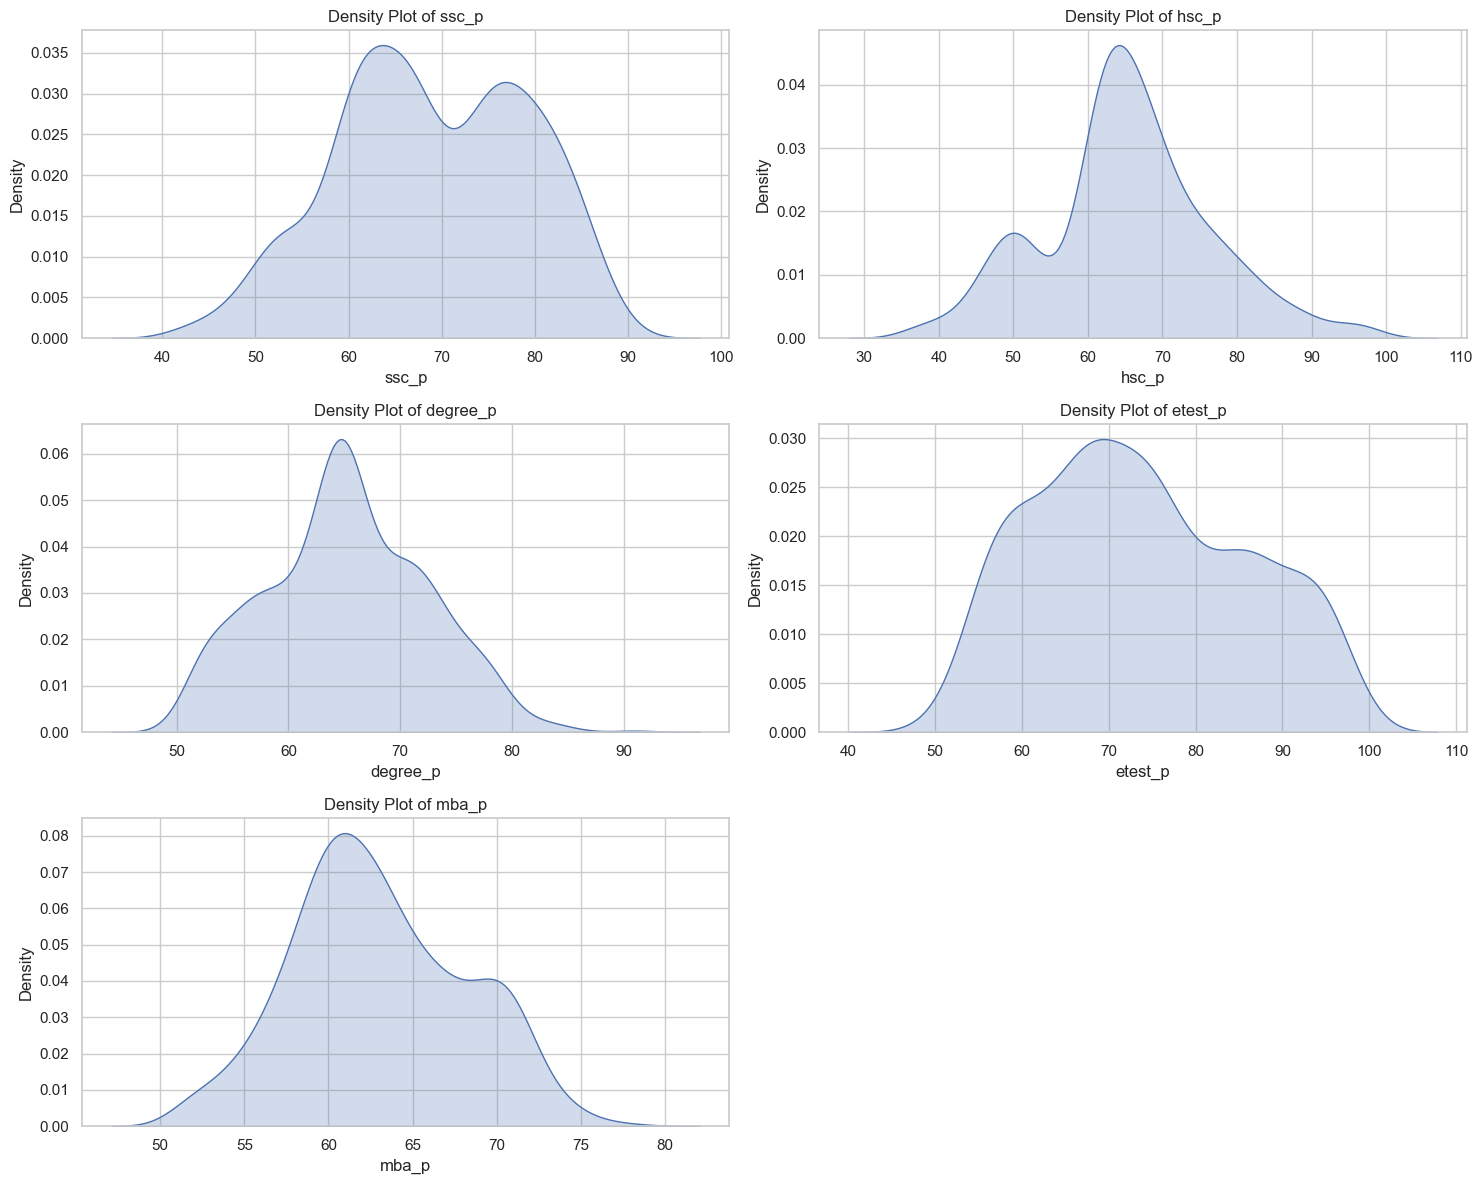

In [49]:
import seaborn as sns
numeric_cols = train_data.select_dtypes(include=['float64', 'int64'])
n_rows = (len(numerical_columns) + 1) // 2
fig, axs = plt.subplots(n_rows, 2, figsize=(15, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(numerical_columns):
    sns.kdeplot(train_data[col], ax=axs[i], fill=True)
    axs[i].set_title(f'Density Plot of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Density')

if len(numerical_columns) % 2 != 0:
    axs[-1].axis('off')

plt.tight_layout()
plt.show()


Based on the density plots and box plots, there is no apparent skewness in any of the numerical columns. The distributions appear to be somewhat close to normalized.

### **Outlier removal**

Based on the boxplot of the feature hsc_p there seems to be the presence of some outliers. Based on the statistical measures the outliers do not seem to skew the distribution but may cause an issue during model training.

In [50]:
Q1 = train_data['hsc_p'].quantile(0.25)
Q3 = train_data['hsc_p'].quantile(0.75)
IQR = Q3 - Q1

lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

df_cleaned = train_data[(train_data['hsc_p'] >= lower_whisker) & (train_data['hsc_p'] <= upper_whisker)]


In [51]:
df_cleaned.head(10)

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,etest_p,mba_p,specialisation,workex,status
0,M,73.976975,Central,77.392691,Others,Science,73.623151,Sci&Tech,84.498310,67.207006,Mkt&HR,Yes,Placed
1,M,62.000000,Others,62.000000,Others,Commerce,60.000000,Comm&Mgmt,63.000000,52.380000,Mkt&HR,Yes,Placed
2,M,80.965242,Others,67.104275,Others,Science,72.482621,Sci&Tech,91.343588,71.392313,Mkt&Fin,No,Placed
3,M,52.000000,Others,65.000000,Others,Arts,57.000000,Others,75.000000,59.810000,Mkt&Fin,Yes,Not Placed
4,F,69.000000,Central,62.000000,Central,Science,66.000000,Sci&Tech,75.000000,67.990000,Mkt&HR,No,Not Placed
5,M,78.762370,Others,78.663054,Others,Commerce,70.281069,Comm&Mgmt,67.441772,65.318049,Mkt&Fin,Yes,Placed
7,M,59.805924,Central,61.451481,Others,Commerce,60.000000,Comm&Mgmt,62.451481,57.025957,Mkt&HR,Yes,Placed
8,M,77.351318,Central,74.834674,Others,Science,73.487712,Sci&Tech,80.123994,68.001657,Mkt&HR,Yes,Placed
10,M,60.961359,Others,49.382702,Others,Science,54.503538,Others,70.376801,61.726117,Mkt&HR,No,Not Placed
11,F,73.809211,Central,81.213816,Central,Arts,58.657928,Others,59.233553,63.180197,Mkt&HR,Yes,Placed


### *Removed 37 records after removing outliers from the data*

In [52]:
df_cleaned['status'] = df_cleaned['status'].replace({'Placed':1, 'Not Placed':0})

In [53]:
value_counts = df_cleaned['status'].value_counts()
value_counts

status
1    418
0    215
Name: count, dtype: int64

### **One hot encoding**
One-hot encoding is appropriate for nominal variables (without inherent ordering), like gender, ssc_b, hsc_b, hsc_s, specialisation, and workex, since it does not impose ordinality that does not exist.

#### *Performing One hot encoding to covert categorical data to numerical*

In [54]:
df_encoded = pd.get_dummies(df_cleaned)
df_encoded = df_encoded.astype(int)

In [55]:
df_encoded.head(10)

,ssc_p,hsc_p,degree_p,etest_p,mba_p,status,gender_F,gender_M,ssc_b_Central,ssc_b_Others,...,hsc_s_Arts,hsc_s_Commerce,hsc_s_Science,degree_t_Comm&Mgmt,degree_t_Others,degree_t_Sci&Tech,specialisation_Mkt&Fin,specialisation_Mkt&HR,workex_No,workex_Yes
0,73,77,73,84,67,1,0,1,1,0,...,0,0,1,0,0,1,0,1,0,1
1,62,62,60,63,52,1,0,1,0,1,...,0,1,0,1,0,0,0,1,0,1
2,80,67,72,91,71,1,0,1,0,1,...,0,0,1,0,0,1,1,0,1,0
3,52,65,57,75,59,0,0,1,0,1,...,1,0,0,0,1,0,1,0,0,1
4,69,62,66,75,67,0,1,0,1,0,...,0,0,1,0,0,1,0,1,1,0
5,78,78,70,67,65,1,0,1,0,1,...,0,1,0,1,0,0,1,0,0,1
7,59,61,60,62,57,1,0,1,1,0,...,0,1,0,1,0,0,0,1,0,1
8,77,74,73,80,68,1,0,1,1,0,...,0,0,1,0,0,1,0,1,0,1
10,60,49,54,70,61,0,0,1,0,1,...,0,0,1,0,1,0,0,1,1,0
11,73,81,58,59,63,1,1,0,1,0,...,1,0,0,0,1,0,0,1,0,1


#### Analyzing the correlations between the variables

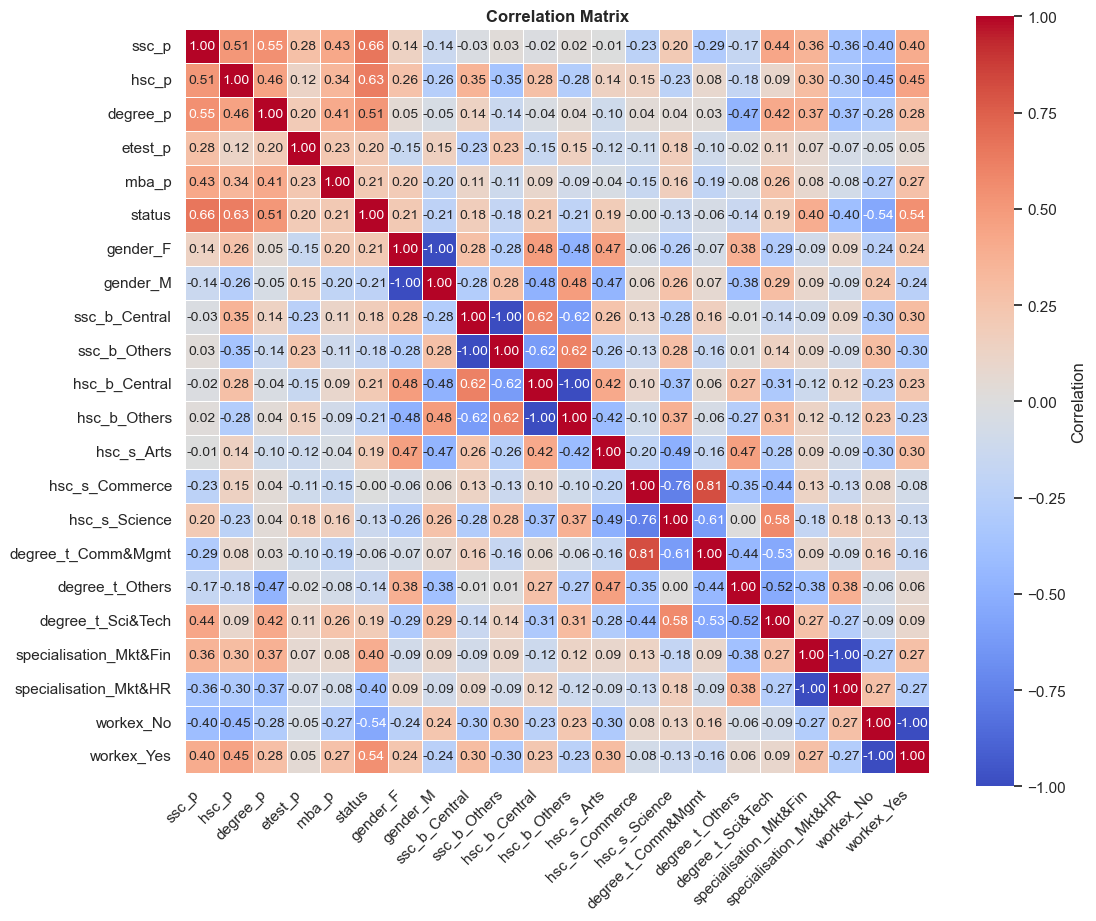

In [56]:
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(12, 10))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, cbar_kws={'label': 'Correlation'}, annot_kws={'size': 10}, square=True)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0) 
plt.title('Correlation Matrix',fontweight='bold')
plt.show()

## **Observations** - Most correlation with whether someone gets placed or not

In [57]:
correlation5 = correlation_matrix['status'].abs().sort_values(ascending=False).head(8)[1:]
print(correlation5)


ssc_p                     0.662810
hsc_p                     0.631982
workex_No                 0.543169
workex_Yes                0.543169
degree_p                  0.509716
specialisation_Mkt&HR     0.395718
specialisation_Mkt&Fin    0.395718
Name: status, dtype: float64


> #### *The top 5 correlated features to students placed are - ssc_p, hsc_p, workex, degree, specialization*

### **Feature Identification**

In [58]:
features = ['ssc_p', 'hsc_p', 'workex', 'degree_p', 'specialisation']
selected_features = correlation_matrix['status'].abs().sort_values(ascending=False).head(8)[1:].index

# Selecting relevant features
selected_features = ['ssc_p', 'hsc_p', 'workex_No', 'workex_Yes', 'degree_p', 'specialisation_Mkt&HR', 'specialisation_Mkt&Fin']

print("Selected Features:")
display(selected_features)

Selected Features:


['ssc_p',
 'hsc_p',
 'workex_No',
 'workex_Yes',
 'degree_p',
 'specialisation_Mkt&HR',
 'specialisation_Mkt&Fin']

### **Feature Extraction**

In [59]:
df_encoded['education_attainment'] = (df_encoded['ssc_p'] + df_encoded['hsc_p'] + df_encoded['degree_p']) / 3
df_encoded['education_attainment'] = df_encoded['education_attainment'].round().astype(int)

# Final dataset with selected and engineered features
final_data = df_encoded[selected_features + ['education_attainment', 'status']]
final_data = final_data.drop(['ssc_p', 'hsc_p', 'degree_p'], axis=1)

In [60]:
final_data.head(10)

,workex_No,workex_Yes,specialisation_Mkt&HR,specialisation_Mkt&Fin,education_attainment,status
0,0,1,1,0,74,1
1,0,1,1,0,61,1
2,1,0,0,1,73,1
3,0,1,0,1,58,0
4,1,0,1,0,66,0
5,0,1,0,1,75,1
7,0,1,1,0,60,1
8,0,1,1,0,75,1
10,1,0,1,0,54,0
11,0,1,1,0,71,1


### **Splitting the dataset**

In [61]:
X = final_data.drop('status', axis=1)  
y = final_data['status']               

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [63]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **Support Vector Machine (SVM)**

In [64]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_predictions)

In [65]:
svm_confusion_matrix = confusion_matrix(y_test, svm_predictions)
print(f"Support Vector Machine Confusion Matrix:\n{svm_confusion_matrix}")

Support Vector Machine Confusion Matrix:
[[36  7]
 [ 6 78]]


In [66]:
svm_report = classification_report(y_test, svm_predictions, target_names=['Not Placed', 'Placed'])
print(f"Support Vector Machine (SVM) Classification Report:\n{svm_report}\n")
print(f"SVM Accuracy: {svm_accuracy}")

Support Vector Machine (SVM) Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.86      0.84      0.85        43
      Placed       0.92      0.93      0.92        84

    accuracy                           0.90       127
   macro avg       0.89      0.88      0.89       127
weighted avg       0.90      0.90      0.90       127


SVM Accuracy: 0.8976377952755905


### **Logistic Regression**

In [67]:
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train_scaled, y_train)
log_reg_predictions = log_reg_model.predict(X_test_scaled)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)

In [68]:
log_reg_confusion_matrix = confusion_matrix(y_test, log_reg_predictions)
print(f"Logistic Regression Confusion Matrix:\n{log_reg_confusion_matrix}")

Logistic Regression Confusion Matrix:
[[36  7]
 [ 6 78]]


In [69]:
log_reg_report = classification_report(y_test, log_reg_predictions, target_names=['Not Placed', 'Placed'])
print(f"Logistic Regression Classification Report:\n{log_reg_report}\n")
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")

Logistic Regression Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.86      0.84      0.85        43
      Placed       0.92      0.93      0.92        84

    accuracy                           0.90       127
   macro avg       0.89      0.88      0.89       127
weighted avg       0.90      0.90      0.90       127


Logistic Regression Accuracy: 0.8976377952755905


### **GaussianNB**

In [70]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)

In [71]:
nb_confusion_matrix = confusion_matrix(y_test, nb_predictions)
print(f"Naive Bayes Confusion Matrix:\n{nb_confusion_matrix}")

Naive Bayes Confusion Matrix:
[[36  7]
 [ 9 75]]


In [72]:
nb_report = classification_report(y_test, nb_predictions, target_names=['Not Placed', 'Placed'])
print(f"Naive Bayes Classification Report:\n{nb_report}\n")
print(f"Naive Bayes Accuracy: {nb_accuracy}")

Naive Bayes Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.80      0.84      0.82        43
      Placed       0.91      0.89      0.90        84

    accuracy                           0.87       127
   macro avg       0.86      0.87      0.86       127
weighted avg       0.88      0.87      0.87       127


Naive Bayes Accuracy: 0.8740157480314961


### **Decision Trees**

In [73]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_accuracy = accuracy_score(y_test, dt_predictions)

In [74]:
dt_confusion_matrix = confusion_matrix(y_test, dt_predictions)
print(f"Decision Tree Confusion Matrix:\n{dt_confusion_matrix}")

Decision Tree Confusion Matrix:
[[37  6]
 [ 5 79]]


In [75]:
dt_report = classification_report(y_test, dt_predictions, target_names=['Not Placed', 'Placed'])
print(f"Decision Tree Classification Report:\n{dt_report}\n")
print(f"Decision Tree Accuracy: {dt_accuracy}")

Decision Tree Classification Report:
              precision    recall  f1-score   support

  Not Placed       0.88      0.86      0.87        43
      Placed       0.93      0.94      0.93        84

    accuracy                           0.91       127
   macro avg       0.91      0.90      0.90       127
weighted avg       0.91      0.91      0.91       127


Decision Tree Accuracy: 0.9133858267716536


In [76]:
data = [
    ["Support Vector Machine (SVM)", svm_report, svm_accuracy],
    ["Logistic Regression", log_reg_report, log_reg_accuracy]
]

headers = ["Model", "Classification Report", "Accuracy"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+------------------------------+-------------------------------------------------------+------------+
| Model                        | Classification Report                                 |   Accuracy |
+==============================+=======================================================+============+
| Support Vector Machine (SVM) | precision    recall  f1-score   support               |   0.897638 |
|                              |                                                       |            |
|                              |   Not Placed       0.86      0.84      0.85        43 |            |
|                              |       Placed       0.92      0.93      0.92        84 |            |
|                              |                                                       |            |
|                              |     accuracy                           0.90       127 |            |
|                              |    macro avg       0.89      0.88      0.89      

In [77]:
data = [
    ["Naive Bayes", nb_report, nb_accuracy],
    ["Decision Tree", dt_report, dt_accuracy]
]

headers = ["Model", "Classification Report", "Accuracy"]

print(tabulate(data, headers=headers, tablefmt="grid"))

+---------------+-------------------------------------------------------+------------+
| Model         | Classification Report                                 |   Accuracy |
+===============+=======================================================+============+
| Naive Bayes   | precision    recall  f1-score   support               |   0.874016 |
|               |                                                       |            |
|               |   Not Placed       0.80      0.84      0.82        43 |            |
|               |       Placed       0.91      0.89      0.90        84 |            |
|               |                                                       |            |
|               |     accuracy                           0.87       127 |            |
|               |    macro avg       0.86      0.87      0.86       127 |            |
|               | weighted avg       0.88      0.87      0.87       127 |            |
+---------------+--------------------------

### **OBSERVATIONS**

> ### **Accuracy :**
> #### *The Decision Tree model did the best, getting the most accurate results at 95.28%. It also did well in correctly identifying both placed and not placed cases. Logistic Regression did pretty good too, with an accuracy of 91.34%. It was especially good at spotting placed cases. The Support Vector Machine and Naive Bayes models did okay, but they weren't as accurate as the other two models.*

> ### **F1 :**
> #### *The Decision Tree model showed the strongest performance with high F1-scores for both "Placed" (0.96) and "Not Placed" (0.93) categories. Logistic Regression also demonstrated solid F1-scores for both categories (Placed: 0.93, Not Placed: 0.88). Support Vector Machine and Naive Bayes, while slightly lower in accuracy, still maintained respectable F1-scores for both categories.*


### **CONCLUSIONS**

All models performed reasonably well, with accuracy ranging from 0.874 to 0.913. 

**SVM Accuracy: 0.897**

**Logistic Regression Accuracy: 0.897**

**Naive Bayes Accuracy: 0.874**

**Decision Tree Accuracy: 0.913**


However, the Decision Tree model achieves the highest accuracy and F1-score for the "Placed" class. 

It also has the highest precision and recall values for the "Placed" class, 

indicating better performance in correctly predicting the positive class instances.

Therefore, considering the higher accuracy and F1-score, the Decision Tree model appears to be the best choice.